# Library design for MOP mm10

by Pu Zheng

2020.11.01

In [1]:
%run "E:\Users\puzheng\Documents\Startup_py3.py"
sys.path.append(r"E:\Users\puzheng\Documents")

import ImageAnalysis3
from ImageAnalysis3 import get_img_info, visual_tools, corrections, library_tools

from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt

%matplotlib notebook
print(os.getpid())

1336


# 1 Extract region sequences

In [2]:
## Some folders
# human genome
genome_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\mm10'
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_MOP'

In [3]:
resolution = 10000
flanking = 100000
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'Slc17a7_{int(resolution/1000)}kb')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)

In [4]:
reload(library_tools.sequences)
seq_dic_list, reg_list = library_tools.sequences.Batch_Extract_Sequences(library_folder, genome_folder, 
                                                                         merge=False, save=True,
                                                                         resolution=resolution, flanking=flanking)

Input region file is: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_MOP\Slc17a7_10kb\Regions.txt
['mm10.fa', 'mrna.fa', 'RepBase_Repeat.fasta']
mm10.fa
-writing region number:60


# 2. Design probe targeting sequences by probe_designer


## 2.1 Construct count table with all the 17-mers in the genome

Only do this if you don't have pre-built 17-mer

However you can do almost the same thing for your own library during quality check

This library requires mm9 genome

### construct map for whole genome

In [66]:
reload(library_tools)
reload(library_tools.design)
pb_designer = library_tools.design.pb_reports_class(
    sequence_dic={'file':input_files,
                  'rev_com':True, # design two strands
                  'two_stranded':True},
    map_dic={'genome':{'file':genome_index,'rev_com':False,'two_stranded':True},
             'transcriptome':{'file':transcriptome_index,'rev_com':True,'two_stranded':False},
             'rep_genome':{'file':repeat_index,'rev_com':False,'two_stranded':True},
             'self_sequences':{'file':input_files,'force_list':True,'rev_com':False,'two_stranded':True},
             'ref_merfish':{'file':ref_merfish_index,'rev_com':False,'two_stranded':True},
             },
        save_file=save_file,
)
print(pb_designer)
pb_designer.load_from_file()


Probe designer derived from Bogdan Bintu:
https://github.com/BogdanBintu/ChromatinImaging/blob/master/LibraryDesign/LibraryDesigner.py
by Pu Zheng, 2020.11

Major changes:
    1. allow design of two strands
    2. separate reverse_compliment (rev_com) and from two strands (two_stranded) as 
    two different inputs for map_dic and sequence_dic
    3. replace 'local_genome' with 'self_sequences' to be more explicit, and only 
    exclude the counts for the corresponding self_sequence within each input. 

Key information:
    - number of input_sequence(s): 22
    - save_file location: None

- Fail to load from savefile: None, file doesn't exist.


False

In [ ]:
from tqdm import tqdm
# genome
reload(ld)
names,seqs = lt.fastaread(os.path.join(genome_folder, 'mm10.fa'))
ct = ld.countTable(word=17,save_file=os.path.join(genome_folder, 'mm10_genome_17w.npy'), sparse=False)
print(ct.save_file)
for iseq in tqdm(range(len(seqs))):
    print(names[iseq], end=' ')
    ct.consume(seqs[iseq],verbose=True)
ct.complete(verbose=True)
ct.save()

### construct map for transcriptome

In [ ]:
from tqdm import tqdm
# transcriptome
reload(ld)
names,seqs = lt.fastaread(os.path.join(genome_folder, 'mrna.fa'))
ct = ld.countTable(word=17,save_file=os.path.join(genome_folder, 'mm10_transcriptome_17w.npy'), sparse=False)
print(ct.save_file)
for iseq in tqdm(range(len(seqs))):
    print(names[iseq], end=' ')
    ct.consume(seqs[iseq],verbose=True)
ct.complete(verbose=True)
ct.save()

In [ ]:
from tqdm import tqdm
reload(lt)

# repeats
names,seqs = lt.fastaread(os.path.join(genome_folder, 'mm10.fa'))
rep_names, rep_seqs = [], []
for _name, _seq in zip(names, seqs):
    _sub_names, _sub_seqs = lt.extract_lower_case(_name, _seq)
    rep_names += _sub_names
    rep_seqs += _sub_seqs
print(len(rep_names), len(rep_seqs))

ct = ld.countTable(word=17,save_file=os.path.join(genome_folder, 'mm10_genome_repeats_17w.npy'), sparse=False)
for iseq in tqdm(range(len(rep_seqs))):
    print(rep_names[iseq], end=' ')
    ct.consume(rep_seqs[iseq],verbose=True)
ct.complete(verbose=True)
ct.save()

### construct map for meng's MOP MERFISH library

In [ ]:
ref_lib_filename = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Existing_MERFISH\M1_meng.fasta'
names,seqs = lt.fastaread(ref_lib_filename)

ct = ld.countTable(word=17,save_file=os.path.join(pool_folder, 'M1_meng_MERFISH_17w.npy'), sparse=False)
for iseq in tqdm(range(len(seqs))):
    print(names[iseq], end=' ')
    ct.consume(seqs[iseq],verbose=True)
ct.complete(verbose=True)
ct.save()

## 2.2 Run probe designer

In [68]:
# requires pre_defined genome_folder and library_folder
# Indices
genome_index = os.path.join(genome_folder, r'mm10_genome_17w.npy')
repeat_index = os.path.join(genome_folder, r'repbase_genome_repeats_17w.npy')
transcriptome_index = os.path.join(genome_folder, r'mm10_transcriptome_17w.npy') # NA for this design
ref_merfish_index = os.path.join(pool_folder, 'M1_meng_MERFISH_17w.npy') # merfish designed by Meng
# get input files 
input_files = glob.glob(os.path.join(sequence_folder, 'Slc17a7', '*.fasta'))
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')

print(f"{len(input_files)} regions loaded to design probes.")
overwrite = True

if not os.path.exists(report_folder):
    os.makedirs(report_folder)

0 regions loaded to design probes.


In [ ]:
%matplotlib inline
save_file = os.path.join(report_folder, f'merged_probes_supp_{int(resolution/1000)}kb.pbr')#'/pb_reports_reg_'+str(-i-1)+'.pbr'
if not os.path.exists(save_file) or overwrite: # if probe report file doesnt exist

    #local_genome_fl = in_file
    #print(in_file)
    pb_designer = ld.pb_reports_class(
        sequence_dic={'file':input_files,
                      'use_revc':True, # design two strands
                      'use_kmer':True},
        map_dic={'genome':{'file':genome_index,'use_revc':True,'use_kmer':True},
                 'transcriptome':{'file':transcriptome_index,'use_revc':False,'use_kmer':True},
                 'rep_genome':{'file':repeat_index,'use_revc':True,'use_kmer':True},
                 'local_genome':{'file':input_files,'force_list':True,'use_revc':True,'use_kmer':True},
                 'ref_merfish':{'file':ref_merfish_index,'use_revc':False,'use_kmer':True},
                 },
        save_file=save_file,
        params_dic={'word_size':17,'pb_len':42,'buffer_len':0,'max_count':2**16-1,'check_on_go':False,'auto':False},
        dic_check={#'genome':25+75, 
                   ('genome','local_genome'):25,
                   'rep_genome':0,
                   'transcriptome':25, # only one hit of 30 mer allowed
                   #'local_genome':40, 
                   'ref_merfish': 25,
                   'gc':[0.25,0.85],'tm':70})

    pb_designer.computeOTmaps()
    pb_designer.compute_pb_report()
    pb_designer.perform_check_end()
    pb_designer.plots()
    pb_designer.save_csv()
    print(f"-- number of probes kept: {len(pb_designer.pb_reports_keep)}")

In [45]:
save_file = os.path.join(report_folder, f'merged_probes_supp_{int(resolution/1000)}kb.pbr')#'/pb_reports_reg_'+str(-i-1)+'.pbr'
pbde = ld.pb_reports_class()
pbde.load_pbr(save_file)

In [47]:
pbde.pb_reports

{b'TACTTTACCCACTTAGAGCAAACAATTCAGTGGTTTGTAGTA': {'name': 'chr7:45063949-45073949_reg_1_pb_0',
  'reg_index': 0,
  'reg_name': 'chr7:45063949-45073949_reg_1',
  'pb_index': 0,
  'gc': 0.35714285714285715,
  'tm': 74.76584927171695,
  'genome': 41,
  'transcriptome': 0,
  'rep_genome': 0,
  'local_genome': 26,
  'ref_merfish': 0},
 b'ACTTTACCCACTTAGAGCAAACAATTCAGTGGTTTGTAGTAT': {'name': 'chr7:45063949-45073949_reg_1_pb_1',
  'reg_index': 0,
  'reg_name': 'chr7:45063949-45073949_reg_1',
  'pb_index': 1,
  'gc': 0.35714285714285715,
  'tm': 74.76584927171683,
  'genome': 42,
  'transcriptome': 0,
  'rep_genome': 0,
  'local_genome': 26,
  'ref_merfish': 0},
 b'CTTTACCCACTTAGAGCAAACAATTCAGTGGTTTGTAGTATA': {'name': 'chr7:45063949-45073949_reg_1_pb_2',
  'reg_index': 0,
  'reg_name': 'chr7:45063949-45073949_reg_1',
  'pb_index': 2,
  'gc': 0.35714285714285715,
  'tm': 74.00881570159424,
  'genome': 44,
  'transcriptome': 0,
  'rep_genome': 0,
  'local_genome': 26,
  'ref_merfish': 0},
 b'TTTA

## 2.3 summarize into a pb_dict

In [4]:
verbose=True
cand_prob_nums = []
pb_dic = {}
# Parse segemented list
_save_file = os.path.join(report_folder, f'merged_probes_supp_{int(resolution/1000)}kb.pbr')
_pbde = ld.pb_reports_class()
_pbde.load_pbr(_save_file)

reg_inds = np.unique([_v['reg_index'] for _s, _v in _pbde.pb_reports_keep.items()])
for _rid in reg_inds:
    _sel_pbs = {_s:_v for _s, _v in _pbde.pb_reports_keep.items() if _v['reg_index']==_rid}

    if len(_sel_pbs) > 0:
        _region_gid = list(_sel_pbs.values())[0]['reg_name'].split('_')[-1]
        cand_prob_nums.append(len(_sel_pbs))
        if verbose:
            print(f"-- appending region:{_region_gid} with {len(_sel_pbs)} probes")
        _splitted_pbde = ld.pb_reports_class()
        _splitted_pbde.pb_reports_keep = _sel_pbs
        pb_dic[int(_region_gid)] = _splitted_pbde

-- appending region:1 with 113 probes
-- appending region:2 with 106 probes
-- appending region:4 with 2 probes
-- appending region:5 with 104 probes
-- appending region:6 with 104 probes
-- appending region:7 with 146 probes
-- appending region:8 with 157 probes
-- appending region:9 with 167 probes
-- appending region:10 with 68 probes
-- appending region:12 with 21 probes
-- appending region:13 with 175 probes
-- appending region:14 with 161 probes
-- appending region:15 with 143 probes
-- appending region:16 with 118 probes
-- appending region:17 with 120 probes
-- appending region:18 with 68 probes
-- appending region:19 with 44 probes
-- appending region:20 with 161 probes
-- appending region:21 with 151 probes
-- appending region:22 with 148 probes


In [5]:
# filter by genome counts
num_probes_kept = 150 # max num of probes kept for each region
filtered_pb_dic = library_tools.quality_check.Screen_probe_by_hit(library_folder, pb_dic, num_probes_kept,
                                                                  hit_type='genome')

- Screen probes by genome counts.
-- filtering region:1, directly append 113 probes
-- filtering region:2, directly append 106 probes
-- filtering region:4, directly append 2 probes
-- filtering region:5, directly append 104 probes
-- filtering region:6, directly append 104 probes
-- filtering region:7, directly append 146 probes
-- filtering region:8, screen genome to keep 150 probes
-- filtering region:9, screen genome to keep 150 probes
-- filtering region:10, directly append 68 probes
-- filtering region:12, directly append 21 probes
-- filtering region:13, screen genome to keep 150 probes
-- filtering region:14, screen genome to keep 150 probes
-- filtering region:15, directly append 143 probes
-- filtering region:16, directly append 118 probes
-- filtering region:17, directly append 120 probes
-- filtering region:18, directly append 68 probes
-- filtering region:19, directly append 44 probes
-- filtering region:20, screen genome to keep 150 probes
-- filtering region:21, screen g

In [6]:
## filter by minimum number of probes in each region
min_num_probes = 25 
removed_regions = []
for _rid, _pb_class in filtered_pb_dic.items():
    if len(_pb_class.pb_reports_keep) < min_num_probes:
        print(f"region: {_rid} removed with {len(_pb_class.pb_reports_keep)} probes")
        removed_regions.append(_rid)
for _rid in removed_regions:
    del(filtered_pb_dic[_rid])

region: 4 removed with 2 probes
region: 12 removed with 21 probes


## 2.4 check candidate probe number per region

In [8]:
pb_num_dict = {_k:len(_v.pb_reports_keep) for _k,_v in filtered_pb_dic.items()}

<IPython.core.display.Javascript object>


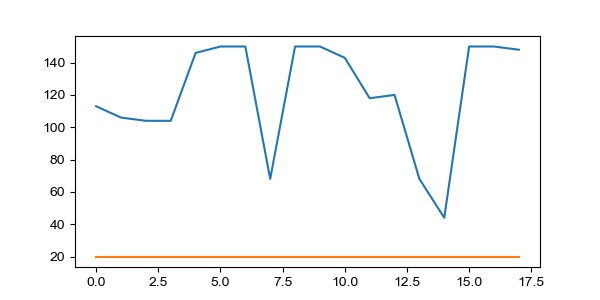

In [9]:
pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
plt.plot(np.ones(len(pb_nums))*20)

# 3. Load and asssemble probes

## 3.1 design readout mapping dict (region_to_readout)

In [16]:
num_readout_per_probe = 2
total_readout_usage = 0
region_2_readout_dict = {}
for _i, (_k,_v) in enumerate(sorted(filtered_pb_dic.items())):
    region_2_readout_dict[_k] = []
    for _j in range(num_readout_per_probe):
        region_2_readout_dict[_k].append(f"u{int(_i+_j*len(filtered_pb_dic))}")
        total_readout_usage += 1
print(total_readout_usage)

36


## 3.2 loading components

### primers
pick primer set 2, 9 for 5kb (consistent with CTP-06)

In [17]:
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Primers'
primers = library_tools.probes.load_primers([2,9], _primer_folder=primer_folder)

- Picked primer: ID: W1A03_primer_2
Name: W1A03_primer_2
Description: W1A03_primer_2
Number of features: 0
Seq('CCCGCAATGGCTGACAACCG', SingleLetterAlphabet())
- Picked primer: ID: W1A10_primer_9
Name: W1A10_primer_9
Description: W1A10_primer_9
Number of features: 0
Seq('TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG', SingleLetterAlphabet())


### readouts

In [18]:
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Readouts'
readout_start = 0
num_color = 2
readouts = library_tools.probes.load_readouts(total_readout_usage, 
                                              _type='designed_readouts', 
                                              _readout_folder=readout_folder, )

readout_dict = {'u': readouts}

## 3.3 assemble probes

In [19]:
reload(library_tools.probes)
from ImageAnalysis3.library_tools.probes import Assemble_probes

cand_probes, readout_summary = Assemble_probes(library_folder, filtered_pb_dic, 
                                               region_2_readout_dict, readout_dict, primers, 
                                               primer_len=19,
                                               rc_targets=False, overwrite=True)

- Assemble probes by given target sequences, readouts and primers.
-- included readout types: ['u']
[] ID: Stv_3
Name: Stv_3
Description: Stv_3 old_barcode
Number of features: 0
Seq('ACAAATCCGACCAGATCGGACGATCATGGG', SingleLetterAlphabet())
[SeqRecord(seq=Seq('ACAAATCCGACCAGATCGGACGATCATGGG', SingleLetterAlphabet()), id='Stv_3', name='Stv_3', description='Stv_3 old_barcode', dbxrefs=[])] ID: Stv_9
Name: Stv_9
Description: Stv_9 old_barcode
Number of features: 0
Seq('GCATGAGTTGCCTGGCGTTGCGACGACTAA', SingleLetterAlphabet())
--- assemblying 113 probes in region: 1
[] ID: Stv_32
Name: Stv_32
Description: Stv_32 old_barcode
Number of features: 0
Seq('AGACGACGCACGTTCGTACCGCGTACTTCG', SingleLetterAlphabet())
[SeqRecord(seq=Seq('AGACGACGCACGTTCGTACCGCGTACTTCG', SingleLetterAlphabet()), id='Stv_32', name='Stv_32', description='Stv_32 old_barcode', dbxrefs=[])] ID: Stv_40
Name: Stv_40
Description: Stv_40 old_barcode
Number of features: 0
Seq('AATCCGGCGTACGTAAGGCAGCTTGCGTTA', SingleLetterAlphabet(

# 4.Check quality

In [20]:
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

## 4.1 Load probes

In [21]:
# folder for this library
# candidate full-length probe filename
candidate_full_name = 'candidate_probes.fasta'
# load full probes
full_records = []
with open(os.path.join(library_folder, candidate_full_name), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        full_records.append(record)

print(f"Total probe loaded: {len(full_records)}")

Total probe loaded: 2182


In [23]:
num_readout_per_probe = 2
primer_len=19
min_num_probes = 25 

In [26]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], primer_len=primer_len)

reg_size_dic, len_check = check._check_region_size(full_records, 
                                                   min_size=min_num_probes)

reg_readout_dic, reg2readout_check = check._check_region_to_readouts(full_records, readout_dict, 
                                                                     total_readout_num=num_readout_per_probe)

readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, full_records, 
                                                                    readout_dict, primer_len=primer_len, 
                                                                    probe_readout_num=num_readout_per_probe)

-- Checking primer usage, total probes: 2182
--- Forward primer incorrect!
gene: 1 -> 113
gene: 2 -> 106
gene: 5 -> 104
gene: 6 -> 104
gene: 7 -> 146
gene: 8 -> 150
gene: 9 -> 150
gene: 10 -> 68
gene: 13 -> 150
gene: 14 -> 150
gene: 15 -> 143
gene: 16 -> 118
gene: 17 -> 120
gene: 18 -> 68
gene: 19 -> 44
gene: 20 -> 150
gene: 21 -> 150
gene: 22 -> 148
1 -> ['Stv_3', 'Stv_9']
2 -> ['Stv_32', 'Stv_40']
5 -> ['Stv_91', 'Stv_101']
6 -> ['Stv_4', 'Stv_10']
7 -> ['Stv_33', 'Stv_42']
8 -> ['Stv_92', 'Stv_104']
9 -> ['Stv_5', 'Stv_11']
10 -> ['Stv_35', 'Stv_44']
13 -> ['Stv_94', 'Stv_105']
14 -> ['Stv_6', 'Stv_12']
15 -> ['Stv_36', 'Stv_45']
16 -> ['Stv_95', 'Stv_106']
17 -> ['Stv_7', 'Stv_13']
18 -> ['Stv_37', 'Stv_46']
19 -> ['Stv_99', 'Stv_107']
20 -> ['Stv_8', 'Stv_14']
21 -> ['Stv_39', 'Stv_48']
22 -> ['Stv_100', 'Stv_109']
-- extracting probes from >region:1, region:2, region:5, region:6, region:7, region:8, region:9, region:10, region:13, region:14, region:15, region:16, region:17, regio

In [27]:
# construct internal map
int_map = check._construct_internal_map(full_records, library_folder) 

-- saving internal 17-mer map to file:\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_MOP\Slc17a7_10kb\probe_table_17.npz


In [28]:
# internal check probes
readout_count_dic, readout_count_check = check._check_readout_in_probes(readout_reg_dic, reg_size_dic, int_map, readout_dict)

kept_records, removed_count = check._check_between_probes(full_records, int_map)
# save kept records
with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'w') as output_handle:
    SeqIO.write(kept_records, output_handle, "fasta")

-- total probes removed by internal screening: 0


## 4.2 BLAST screening of probes

create the local blast database by:
```bash
makeblastdb -in mm10.fa -parse_seqids -dbtype nucl -out mm10
```

The outputs are:
```bash
Building a new DB, current time: 11/02/2020 15:16:50
New DB name:   Z:\Libraries\Genomes\mouse\mm10\mm10
New DB title:  mm10.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
```

In [29]:
check.Blast_probes(kept_records, library_folder, num_threads=32, blast_db=os.path.join(genome_folder, 'mm10'))

- Blast probe against \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\mm10\mm10
-- number of probes loaded: 2182
--- processing region: 1 with 113 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_MOP\Slc17a7_10kb\blast\probe_gene_1.fasta
-- *blasting region: 1
--- total time for blast 1: 14.386693954467773
--- processing region: 10 with 68 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_MOP\Slc17a7_10kb\blast\probe_gene_10.fasta
-- *blasting region: 10
--- total time for blast 10: 9.10476803779602
--- processing region: 13 with 150 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_MOP\Slc17a7_10kb\blast\probe_gene_13.fasta
-- *blasting region: 13
--- total time for blast 13: 12.779499530792236
--- processing region: 14 with 150 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_MOP\Slc17a7_10kb\blast\probe_gene_14.fasta
-- *blasting region: 14
--- total time for blast 14: 13.03

### 4.2.1 screen probe by blast results

This step has 2 different cutoffs:

hard_cutoff: whether a probe has any ~40mer hit somewhere else, if so just dump the probe

soft_cutoff: whether a probe has a lot of ~20mer off-target hits, if exceed certain amount then dump the probe

In [30]:
# screen
num_probes_per_region = 150
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = check.Screening_Probes_by_Blast(library_folder, 
                                                                                             num_probes_per_region,
                                                                                             )

- Number of probes loaded: 2182
- Number of regions in this library: 18
-- checking probes in region: 1
--- gene=1, id=16 removed by soft count = 95
--- gene=1, id=26 removed by soft count = 138
--- gene=1, id=27 removed by soft count = 158
--- gene=1, id=33 removed by soft count = 32
--- gene=1, id=34 removed by soft count = 34
--- gene=1, id=66 removed by soft count = 2021
--- gene=1, id=72 removed by soft count = 58
--- gene=1, id=88 removed by soft count = 136
--- number of probes: 113 , kept by blast: 105 , if remove dups: 105
-- number of probes kept for this region: 105
-- checking probes in region: 2
--- gene=2, id=30 removed by soft count = 46
--- gene=2, id=83 removed by soft count = 368
--- gene=2, id=88 removed by soft count = 78
--- gene=2, id=89 removed by soft count = 278
--- gene=2, id=94 removed by soft count = 167
--- number of probes: 106 , kept by blast: 101 , if remove dups: 101
-- number of probes kept for this region: 101
-- checking probes in region: 5
--- gene=

## 4.3 an extra round of check (could be skipped)

In [31]:
num_readout_per_probe = 2
primer_len=19
min_num_probes = 25 

In [33]:
# check primers
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], 
                                         primer_len=primer_len)
print(primer_check)
# check region probe number (size)
reg_size_dic, len_check = check._check_region_size(kept_pbs,
                                                   min_size=min_num_probes)
print(len_check)
# check whether readouts in each region are correct
reg_readout_dic, reg2readout_check = check._check_region_to_readouts(kept_pbs, readout_dict, 
                                                                     total_readout_num=num_readout_per_probe)
print(reg2readout_check)
# check readouts vs regions
readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, kept_pbs, 
                                                                    readout_dict, 
                                                                    primer_len=primer_len, 
                                                                    probe_readout_num=num_readout_per_probe)
print(readout2reg_check)
# build internal check map
int_map = check._construct_internal_map(kept_pbs, library_folder)
# in each probe check readouts
readout_count_dic, readout_count_check = check._check_readout_in_probes(readout_reg_dic, reg_size_dic, 
                                                                        int_map, readout_dict)
print(readout_count_check)
# check between probes
kept_records, removed_count = check._check_between_probes(kept_pbs, int_map)

-- Checking primer usage, total probes: 2182
--- Forward primer incorrect!
False
gene: 1 -> 105
gene: 2 -> 101
gene: 5 -> 98
gene: 6 -> 100
gene: 7 -> 142
gene: 8 -> 146
gene: 9 -> 147
gene: 10 -> 67
gene: 13 -> 149
gene: 14 -> 147
gene: 15 -> 137
gene: 16 -> 115
gene: 17 -> 118
gene: 18 -> 60
gene: 19 -> 26
gene: 20 -> 144
gene: 21 -> 146
gene: 22 -> 143
True
1 -> ['Stv_3', 'Stv_9']
2 -> ['Stv_32', 'Stv_40']
5 -> ['Stv_91', 'Stv_101']
6 -> ['Stv_4', 'Stv_10']
7 -> ['Stv_33', 'Stv_42']
8 -> ['Stv_92', 'Stv_104']
9 -> ['Stv_5', 'Stv_11']
10 -> ['Stv_35', 'Stv_44']
13 -> ['Stv_94', 'Stv_105']
14 -> ['Stv_6', 'Stv_12']
15 -> ['Stv_36', 'Stv_45']
16 -> ['Stv_95', 'Stv_106']
17 -> ['Stv_7', 'Stv_13']
18 -> ['Stv_37', 'Stv_46']
19 -> ['Stv_99', 'Stv_107']
20 -> ['Stv_8', 'Stv_14']
21 -> ['Stv_39', 'Stv_48']
22 -> ['Stv_100', 'Stv_109']
True
-- extracting probes from >region:1, region:2, region:5, region:6, region:7, region:8, region:9, region:10, region:13, region:14, region:15, region:16, r

# 5. Save

## 5.1 save fasta

In [35]:
final_probe_folder = os.path.join(library_folder, 'final_probes')
if not os.path.exists(final_probe_folder):
    os.makedirs(final_probe_folder)
    
# save kept records
final_savefile = os.path.join(library_folder, 'final_probes', 'extra_filtered_full_probes.fasta')
with open(final_savefile, 'w') as output_handle:
    print(final_savefile)
    SeqIO.write(kept_records, output_handle, "fasta")

\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_MOP\Slc17a7_10kb\final_probes\extra_filtered_full_probes.fasta


## 5.2 save csv

In [36]:
import csv

with open(os.path.join(final_probe_folder, 'extra_filtered_full_probes.csv'), 'w', newline='') as _file:
    _writer = csv.writer(_file, dialect='excel')
    # write csv
    for _r in kept_records:
        _writer.writerow([_r.id, str(_r.seq)])

## This section is to parse readouts

In [ ]:
# biopython
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

In [ ]:
all_ndbs = []
with open(os.path.join(readout_folder, 'updated_NDBs.fasta'), 'r') as _rd_handle:
    for _readout in SeqIO.parse(_rd_handle, "fasta"):
        all_ndbs.append(_readout)
all_ndbs = [_ndb for _ndb in sorted(all_ndbs, key=lambda v:int(v.name.split('_')[1]))]

In [ ]:
all_stvs = []
with open(os.path.join(readout_folder, 'updated_Stvs.fasta'), 'r') as _rd_handle:
    for _readout in SeqIO.parse(_rd_handle, "fasta"):
        all_stvs.append(_readout)

In [ ]:
len(all_stvs) + len(all_ndbs)

In [ ]:
# split by channel
readout_by_channel = {'750':all_stvs[:25], '647':all_stvs[25:50], '561':all_stvs[50:]}
for _i, _ndb in enumerate(all_ndbs):
    _ndb_id = int(_ndb.name.split('NDB_')[1])
    if _ndb_id % 3 == 1:
        readout_by_channel['750'].append(_ndb)
    elif _ndb_id % 3 == 2:
        readout_by_channel['647'].append(_ndb)
    elif _ndb_id % 3 == 0:
        readout_by_channel['561'].append(_ndb)

In [ ]:
readout_by_channel['561']

In [ ]:
readout_by_channel['647']

In [ ]:
for _k, _v in readout_by_channel.items():
    _save_filename = os.path.join(readout_folder, f'designed_readouts_{_k}.fasta')
    print(_save_filename, len(_v))
    with open(_save_filename, 'w') as _output_handle:
        SeqIO.write(_v, _output_handle, "fasta")